In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emachine as EM
import itertools
from joblib import Parallel, delayed
#from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(0)

In [3]:
n_var = 40 ; g = 0.5 ; n_seq = 5000

In [4]:
# Synthetic data are generated by using `generate_seq`.
w_true,seqs = EM.generate_seq(n_var,n_seq,g=g)
print(seqs.shape)

ops = EM.operators(seqs)
print(ops.shape)

(5000, 40)
(5000, 820)


In [5]:
# predict interactions w
eps_list = np.linspace(0.1,0.9,9)
n_eps = len(eps_list)
res = Parallel(n_jobs = n_eps)(delayed(EM.fit)(ops,eps=eps,max_iter=100) for eps in eps_list)
w_eps = np.array([res[i][0] for i in range(len(res))])
w_eps_iter = np.array([res[i][1] for i in range(len(res))])

#e_eps = np.zeros(len(eps_list))
#w_eps = np.zeros((len(eps_list),ops.shape[1]))
#for i,eps in enumerate(eps_list):
#    w_eps[i,:],e_eps[i] = EM.fit(ops,w_true,eps=eps,max_iter=100)
    #print('eps and e_eps:',eps,e_eps[i])

In [6]:
w_eps_iter.shape

(9, 100, 820)

In [7]:
MSE = ((w_true[np.newaxis,np.newaxis,:] - w_eps_iter)**2).mean(axis=2)
MSE.shape

(9, 100)

In [8]:
# Entropy
#w_iter_eps[n_eps,n_iter,n_ops]
#ops[n_seq,n_ops] 
energy_eps_iter = -np.sum((ops[:,np.newaxis,np.newaxis,:]*w_eps_iter[np.newaxis,:,:,:]),axis=3)
prob_eps_iter = np.exp(energy_eps_iter)  # [n_seq,n_eps,n_iter]
prob_eps_iter /= prob_eps_iter.sum(axis=0)[np.newaxis,:,:] 
entropy_eps_iter = -(prob_eps_iter*np.log(prob_eps_iter)).sum(axis=0) #[n_eps,n_iter] 

In [9]:
entropy_eps_iter.shape

(9, 100)

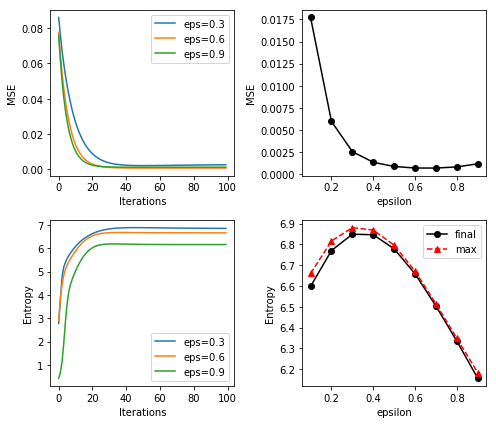

In [10]:
ieps_show = [2,5,8]

nx,ny = 2,2
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))

ax[0,0].plot(MSE[2],label='eps=%1.1f'%eps_list[2])
ax[0,0].plot(MSE[5],label='eps=%1.1f'%eps_list[5])
ax[0,0].plot(MSE[8],label='eps=%1.1f'%eps_list[8])

ax[1,0].plot(entropy_eps_iter[2,:],label='eps=%1.1f'%eps_list[2])
ax[1,0].plot(entropy_eps_iter[5,:],label='eps=%1.1f'%eps_list[5])
ax[1,0].plot(entropy_eps_iter[8,:],label='eps=%1.1f'%eps_list[8])

ax[0,1].plot(eps_list,MSE[:,-1],'ko-')

ax[1,1].plot(eps_list,entropy_eps_iter[:,-1],'ko-',label='final')
ax[1,1].plot(eps_list,entropy_eps_iter[:,:].max(axis=1),'r^--',label='max')

ax[0,0].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_ylabel('MSE')
ax[0,1].set_ylabel('MSE')
ax[1,0].set_ylabel('Entropy')
ax[1,1].set_ylabel('Entropy')

ax[0,0].set_xlabel('Iterations')
ax[0,1].set_xlabel('epsilon')
ax[1,0].set_xlabel('Iterations')
ax[1,1].set_xlabel('epsilon')

plt.tight_layout(h_pad=1, w_pad=1.5)
#plt.savefig('fig.pdf', format='pdf', dpi=100)